## NMF-CC

(0.4388506541602715,
 0.7584905660377359,
 0.4652202471971884,
 0.7584905660377359,
 0.4692223780582827,
 0.7128011972913929,
 0.7584905660377359)

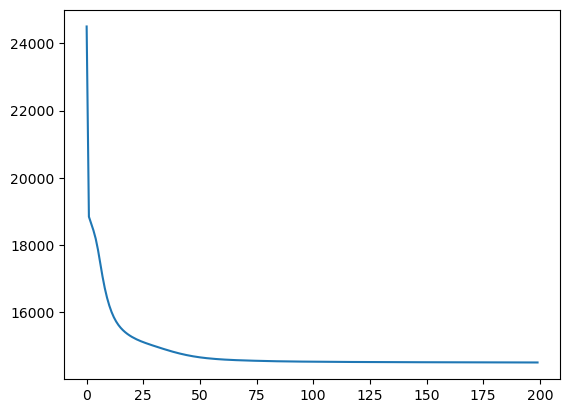

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import adjusted_rand_score as ARI
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
import warnings
warnings.filterwarnings('ignore')
from util import eval, loadDataset, normalization, kmeansInitialization


eps = torch.tensor(10 ** -10)

datasets = ['3Sources.npy',
'BBCSport.npy',
'Caltech101.npy',
'Caltech_2.npy',
'Citeseer.npy',
'Coil100.npy',
'Cora.npy',
'EYaleB10.npy',
'Handwritten.npy',
'MNIST10.npy',
'UCIdigit.npy',
'Umist.npy',
'Yale32.npy',
'Yeast.npy',
'Cora2.npy',
'texas.npy',
'wisconsin.npy',
'washington.npy',
'cornell.npy']


X0, Y, V, c = loadDataset(16)


r = 10
k = 10
alpha = 0.1
beta = 0.1
gamma = 0.1
mu = 0.1
iter = 200

W = []
H = []
X = []

O = torch.ones(r, r)

for v in range(V):

    
    X.append(torch.tensor(X0[v]).type(torch.float32))
    
    d, n = X[v].shape
    
    W0 = torch.rand(d, r)
    H0 = torch.rand(r, n)
    
    W.append(W0)
    H.append(H0)
    
A = []
D = []
for v in range(V):
    
    A0 = kneighbors_graph(X[v].T, k, mode='connectivity', include_self=False).toarray()
    A0 = torch.tensor(A0).type(torch.float32)
    A0 = torch.maximum(A0, A0.T)

    A.append(A0)

    D0 = torch.diag(torch.sum(A0, dim = 1))
    D.append(D0)

    
# Optimization
err = torch.zeros(iter)

for t in range(iter):

    for v in range(V):
        
        # Updating Ws
        Wn = X[v]        @ H[v].T + beta * W[v]
        Wd = W[v] @ H[v] @ H[v].T + beta * (W[v] @ O)
        W[v] = W[v] * (Wn / torch.maximum(Wd, eps))
        
        # Updating Hs
        Q = torch.zeros(r, n)
        for v2 in range(V):
            Q += H[v2] 
        
        Hn = W[v].T @ X[v]                             + gamma * (H[v] @ A[v]) + mu * H[v]
        Hd = W[v].T @ W[v] @ H[v] + alpha * (Q - H[v]) + gamma * (H[v] @ D[v]) + mu * (H[v] @ H[v].T @ H[v])
        H[v] = H[v] * (Hn / torch.maximum(Hd, eps))

        # Calculating cost function
        err[t] += torch.norm(X[v] - W[v] @ H[v]) ** 2 + gamma * torch.trace(H[v] @ (D[v] - A[v]) @ H[v].T) 
           
plt.plot(err)


Hsum = torch.zeros(r, n)
for v in range(V):
    Hsum += H[v]
    
Hfinal = Hsum / V

pred = KMeans(n_clusters=c).fit(Hfinal.T).labels_

nmi, acc, ari, f1mi, f1ma, f1we, pur = eval(Y, pred)
nmi, acc, ari, f1mi, f1ma, f1we, pur